# **Import Library**

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

# **Data Gathering**

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


# **Exploratory Data Analysis**

In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [19]:
len(dataset)

68

(32, 256, 256, 3)
[2 0 0 1 1 1 0 0 2 1 1 1 1 1 1 1 2 1 1 0 1 0 1 0 0 2 1 1 0 0 1 1]


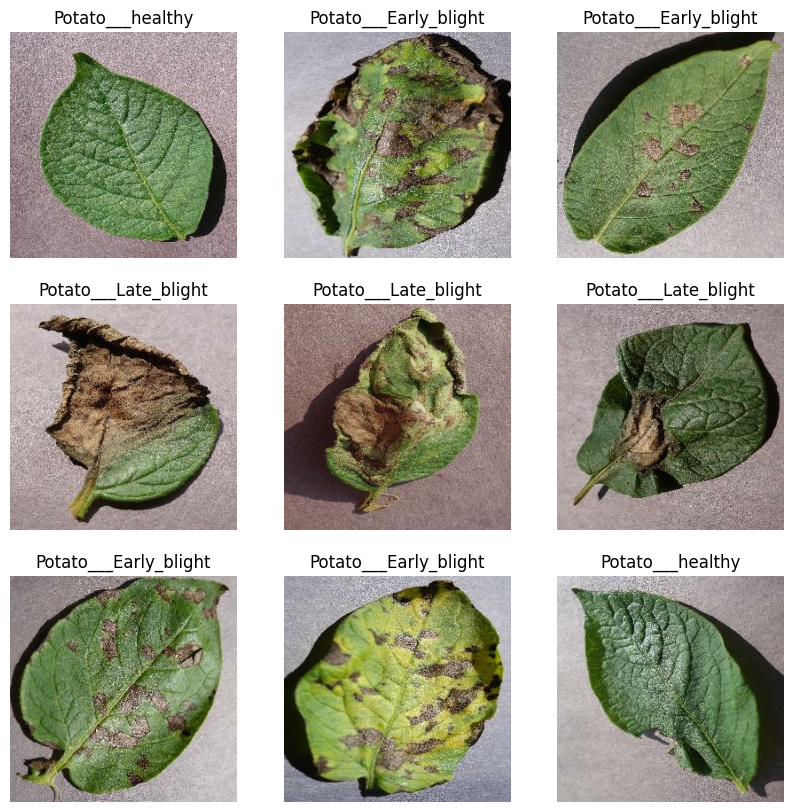

In [20]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    plt.show()
    break

# **Train Test Split**

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# **Data Augmentation**

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# **Build and Train a CNN Model**

In [26]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


54/54 [==============================] - 23s 337ms/step - loss: 0.9169 - accuracy: 0.4871 - val_loss: 0.8570 - val_accuracy: 0.6823
Epoch 2/50
54/54 [==============================] - 18s 309ms/step - loss: 0.7314 - accuracy: 0.6890 - val_loss: 0.4718 - val_accuracy: 0.8274
Epoch 3/50
54/54 [==============================] - 17s 305ms/step - loss: 0.4132 - accuracy: 0.8310 - val_loss: 0.4530 - val_accuracy: 0.8281
Epoch 4/50
54/54 [==============================] - 18s 311ms/step - loss: 0.3286 - accuracy: 0.8703 - val_loss: 0.2728 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 17s 305ms/step - loss: 0.2493 - accuracy: 0.9055 - val_loss: 0.4906 - val_accuracy: 0.8385
Epoch 6/50
54/54 [==============================] - 17s 304ms/step - loss: 0.2378 - accuracy: 0.9061 - val_loss: 0.6553 - val_accuracy: 0.8281
Epoch 7/50
54/54 [==============================] - 17s 308ms/step - loss: 0.2222 - accuracy: 0.9161 - val_loss: 0.3110 - val_accuracy: 0.8750
Epoch 8/50

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 48ms/step - loss: 0.0365 - accuracy: 0.9805


# **Plot Training History**

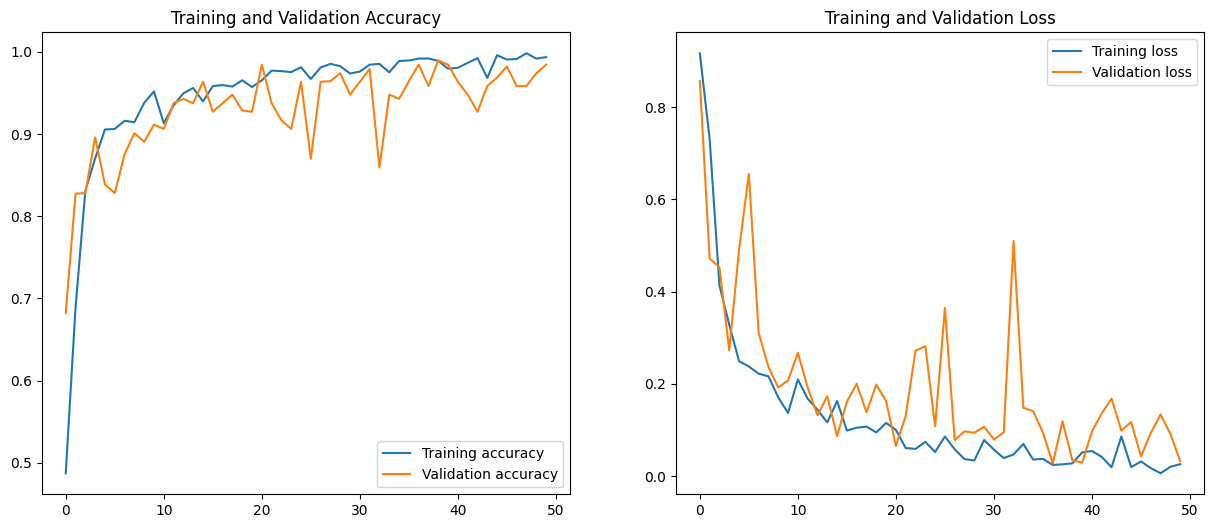

In [30]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

1/1 [==============================] - 0s 42ms/step
predicted label: Potato___Early_blight
actual label: Potato___Early_blight


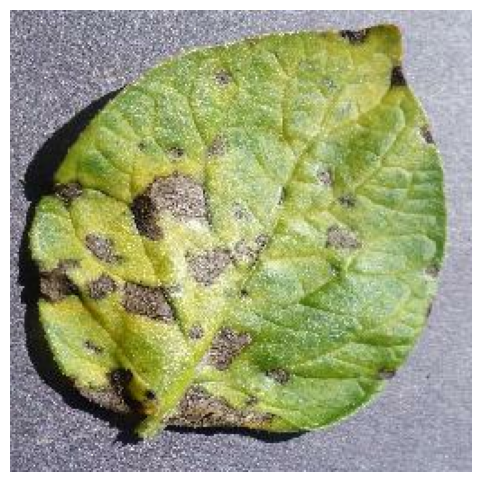

In [41]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    batch_prediction = model.predict(image_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[0])])
    print('actual label:', class_names[first_label])
    plt.figure(figsize=(6, 6))
    plt.imshow(first_image)
    plt.axis("off")
    plt.show()

In [42]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
